# Применение триангуляции Делоне для интерполяции функций двух переменных

## Генерация входных данных

Зададим некоторую функцию, которую мы будем хотеть интерполировать:

In [216]:
import numpy as np

def f(x, y):
    return 3 * x * x + 4 * y * y - 5 * np.sin(x * y)

Далее, сгенерируем точки `points`, в которых значения функции нам будут известны и точки `grid_points`, в которых мы будем значение функции восстанавливать

In [219]:
def get_points(n):
    return np.random.rand(n, 2)

def get_meshgrid(density=100):
    xs = np.linspace(0, 1, density)
    ys = np.linspace(0, 1, density)
    X, Y = np.meshgrid(xs, ys)
    return X, Y

In [236]:
N_points = 20
points = get_points(N_points)
X, Y = get_meshgrid()
grid_points = np.vstack((X.reshape(-1), Y.reshape(-1))).T

Изобразим нашу функцию:

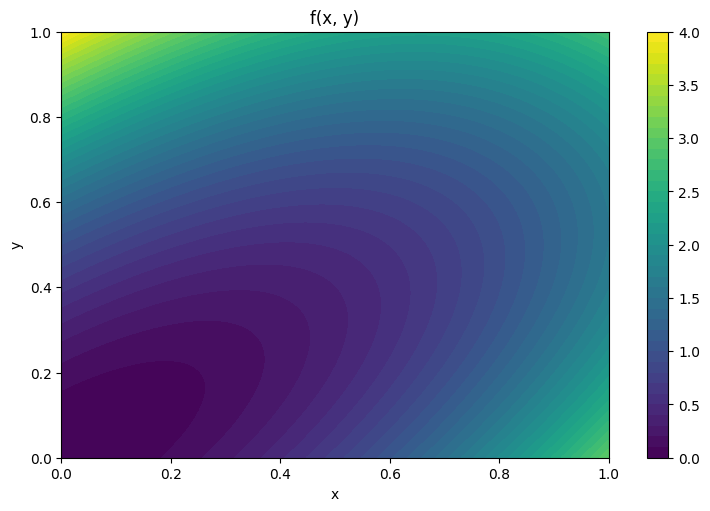

In [268]:
import matplotlib.pyplot as plt

def show_2d_f(fig, ax, f, n_grid_points, X, Y, levels=40):
    grid_points = np.vstack((X.reshape(-1), Y.reshape(-1))).T
    values = np.array([f(i) for i in range(n_grid_points)])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    Z = values.reshape(X.shape)
    cs = ax.contourf(X, Y, Z, levels)
    cbar = fig.colorbar(cs)


fig, ax = plt.subplots(layout='constrained', figsize=(7, 5))
show_2d_f(fig, ax, lambda i: f(grid_points[i,0], grid_points[i,1]), len(grid_points), X, Y)
plt.title('f(x, y)')
plt.show()

## Построение триангуляции Делоне

Теперь построим на точках, в которых мы знаем значения, триангуляцию Делоне.
Дополнительно для каждой точки, в которой значение надо восстановить, узнаем, какому из треугольников она принадлежит.
Поскольку это достаточно ресурсоемкое вычисление, оно вынесено в программу на языке `C++`, здесь же мы просто скомпилируем ее и вызовем:

In [241]:
import os

os.system('g++ -O2 -o main main.cpp');

In [242]:
def get_delaunay(points, other_points):
    # Passing data to the program
    with open('input.txt', 'w') as f:
        f.writelines(f"{len(points)} {len(other_points)}\n")
        f.writelines('\n'.join(list(map(lambda p: f'{p[0]} {p[1]}', points))))
        f.writelines('\n'.join(list(map(lambda p: f'{p[0]} {p[1]}', other_points))))

    # Launching the program
    os.system('./main <input.txt >output.txt')

    # Reading calculated answer
    with open('output.txt', 'r') as f:
        n = int(f.readline())
        triangles = []
        for _ in range(n):
            triangles.append(list(map(int, f.readline().split())))
        triangle_nums = list(map(int, f.readline().split()))
        return triangles, triangle_nums

In [243]:
triangles, triangle_nums = get_delaunay(points, grid_points)

Изобразим построенную триангуляцию:

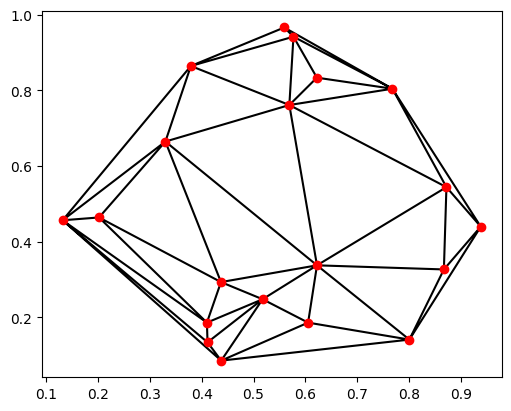

In [257]:
def show_triangulation(fig, ax, points, triangles):
    ax.triplot(points[:,0], points[:,1], triangles, color='black')
    ax.plot(points[:,0], points[:,1], 'o', color='red')

fig, ax = plt.subplots(layout='constrained', figsize=(5, 4))
show_triangulation(fig, ax, points, triangles)
plt.show()

## Интерполяция

Теперь самое интересное -- научимся интерполировать функцию используя лишь ее значения в вершинах триангуляции. Для этого для каждой точки, в которой мы хотим восстановить значение, посмотрим на треугольник в который она попадает (эти данные уже посчитала для нас программа на `C++`), и применим билинейную интерполяцию через значения функции в вершинах треугольника (взяв эти значения с весами, равными барицентрическим координатам нашей точки).
Если точка не попадает ни в один треугольник, восстановить ее значение мы таким способом не можем, поэтому выдадим в таком случае просто 0

In [248]:
# Calculates triangle square (doubled). Used to calculate barycentric coordinates
def get_triangle_2s(p0, p1, p2):
    cross = lambda p1, p2: p1[0] * p2[1] - p2[0] * p1[1]
    return abs(cross(p0, p1) + cross(p1, p2) + cross(p2, p0))


def bilenear_interpolation(triangle_points, triangle_fs, point):
    c0 = get_triangle_2s(triangle_points[1], triangle_points[2], point)
    c1 = get_triangle_2s(triangle_points[2], triangle_points[0], point)
    c2 = get_triangle_2s(triangle_points[0], triangle_points[1], point)
    denom = c0 + c1 + c2
    c0 /= denom
    c1 /= denom
    c2 /= denom
    return triangle_fs[0] * c0 + triangle_fs[1] * c1 + triangle_fs[2] * c2


def interpolate(points, points_fs, triangles, triangle_num, interpolation_point):
    if triangle_num == -1:
        return 0

    triangle = triangles[triangle_num]
    triangle_points = points[triangle]
    triangle_fs = points_fs[triangle]
    return bilenear_interpolation(triangle_points, triangle_fs, interpolation_point)

Теперь можем изобразить уже проинтерполированные значения функции:

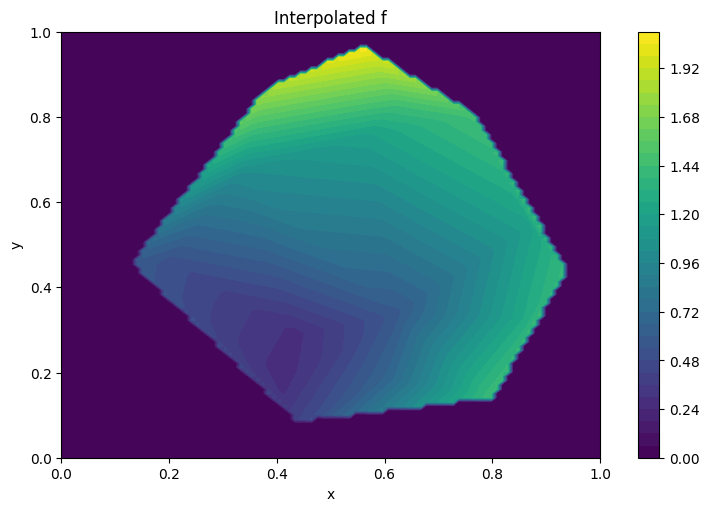

In [269]:
# Calculating values in known points
points_fs = np.array([f(point[0], point[1]) for point in points])

fig, ax = plt.subplots(layout='constrained', figsize=(7, 5))
interpolated = lambda i: interpolate(points, points_fs, triangles, triangle_nums[i], grid_points[i])
show_2d_f(fig, ax, interpolated, len(grid_points), X, Y)
plt.title('Interpolated f')
plt.show()

Наконец, нарисуем график для ошибки интерполяции, совместно с самой триангуляцией.
Для большей наглядности будем считать ошибку в точках, где интерполяция не производилась (т.е. за пределами выпуклой точек с известными значениями функции), равной нулю.

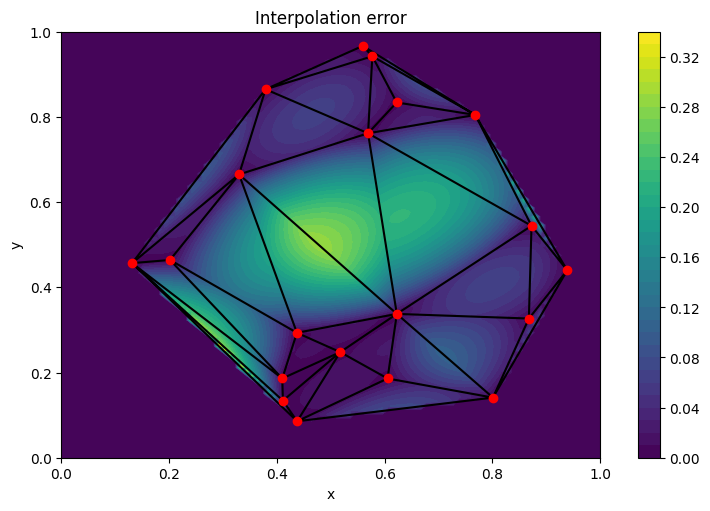

In [270]:
fig, ax = plt.subplots(layout='constrained', figsize=(7, 5))
interpolation_error = lambda i: 0 if triangle_nums[i] == -1 else abs(f(grid_points[i,0], grid_points[i,1]) -
                                    interpolate(points, points_fs, triangles, triangle_nums[i], grid_points[i]))
show_2d_f(fig, ax, interpolation_error, len(grid_points), X, Y)
show_triangulation(fig, ax, points, triangles)
plt.title('Interpolation error')
plt.show()

**Вывод:** Как видим, данный способ дал нам достаточно неплохой метод интерполяции (абсолютная ошибка в среднем порядка 0.15 при значениях функции около 2-3).
Особенно хорошо восстанавливаются значения в точках, близких к вершинам триангуляции.